# GANomaly
- 2020.08.16 : gen 20 / lr 1e-5

# 개발일지
- 2020.08.15 : 분율 추출 구현 / 이상치 상관계수 추출 구현 / 모델 save, load 구현
- 2020.08.16 : anomaly detect 이미지 저장 구현 / 티타늄(Ti64) 상대 밀도 계산 구현

--- 

# Module

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import os
import numpy as np

import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Graph & Animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Hyper Parameter

In [2]:
latent_size = 100  # z벡터의 잠재공간(latent space)의 크기
workers = 4    # 0일때, 약 20% 사용 4일 경우 메모리 100%
img_size = 64
channel = 1
epochs = 100
batch_size = 64
learning_rate = 1e-5

# Data and Device

In [3]:
# 이미지 경로, 이미지들 리사이즈 및 텐서형태로 만들기
#data_root = "../../dataset/train"
DP_aug_data_root = "../../dataset/aug_train/aug_DualPhaseSteel"

data_set = dataset.ImageFolder(root = DP_aug_data_root, # data_root,
                           transform = transforms.Compose([
                                  #transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

print("size of dataset :", len(data_set))

# 배치로 나누고 셔플하기
data_loader = torch.utils.data.DataLoader(data_set, batch_size = batch_size,
                                         shuffle = True, num_workers = workers, drop_last=True)

# Device setting (GPU or CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device :", device)

size of dataset : 990
device : cuda:0


# MODEL

In [4]:
# GANomaly : Generative Adversarial Networks Model using Decoder with AutoEncoder

# === Decoder 모델 ===
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        
        # Batch Normalization 유무에 따른 G_block 정의
        def DC_conv_block(in_features, out_features):
            block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
            ]
            return block
        
        def DC_deconv_block(in_features, out_features, FIRST=True):
            if FIRST:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 1, 0, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            else:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            return block
        
        
        # ======================= 픽셀 분포 생성 layer ======================= 
        self.DC_gen_distribution = nn.Sequential(
            # ------ input is latent_size 100 ------ 
            *DC_deconv_block(latent_size, img_size*8, FIRST=True),
            # ------ state size is 512x4x4 ------ 
            *DC_conv_block(img_size*8, img_size*8),
            # ------ state size is 512x4x4 ------   
            *DC_deconv_block(img_size*8, img_size*4, FIRST=False),
            # ------ state size is 256x8x8 ------ 
            *DC_conv_block(img_size*4, img_size*4),
            # ------ state size is 256x8x8 ------ 
            *DC_deconv_block(img_size*4, img_size*2, FIRST=False),
            # ------ state size is 128x16x16 ------ 
            *DC_conv_block(img_size*2, img_size*2),
            # ------ state size is 128x16x16 ------ 
            *DC_deconv_block(img_size*2, img_size, FIRST=False),
        )
        
        # =================== 가짜 이미지 생성 layer =================== 
        self.DC_gen_fake_img = nn.Sequential(
            # ------ state size is 64x32x32 ------ 
            nn.ConvTranspose2d(img_size, 1, 4, 2, 1, bias=False),
            nn.Tanh() # 픽셀값의 범위 : -1 ~ 1로 두기 위해서
            # ------ state size is 1x64x64 ------ 
        )
    
    def forward(self, input):
        distribution = self.DC_gen_distribution(input)
        fake_img = self.DC_gen_fake_img(distribution)
        
        return fake_img


# === Discriminator 모델 ===
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Batch Normalization 유무에 따른 D_block 정의
        def D_block(in_features, out_features, MP=True):
            if MP:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU(),
                    nn.MaxPool2d(2)
                ]
            return block
        
        # ============== Feature 추출 layer ==============
        self.D_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *D_block(channel, img_size, MP=False),
            # ------ input is 64 x 64 x 64 ------ 
            *D_block(img_size, img_size, MP=True),
            # ------ state is 64 x 32 x 32 ------ 
            *D_block(img_size, img_size*2, MP=False),
            # ------ state is 128 x 32 x 32 ------ 
            *D_block(img_size*2, img_size*2, MP=True),
            # ------ state is 128 x 16 x 16 ------ 
            *D_block(img_size*2, img_size*4, MP=False),
            # ------ state is 256 x 16 x 16 ------ 
            *D_block(img_size*4, img_size*4, MP=True),
            # ------ state is 256 x 8 x 8 ------ 
            *D_block(img_size*4, img_size*8, MP=False),
            # ------ state is 512 x 8 x 8 ------ 
            *D_block(img_size*8, img_size*8, MP=True),
        )
        
        # ===================== 이진 분류 layer =====================
        self.D_classification = nn.Sequential(        
            # ------- state size 512x4x4 ------- 
            nn.Conv2d(img_size*8, channel, 4, 1, 0, bias=False),
            #nn.Linear(fms*8*4*4, 1, bias=False),
            nn.Sigmoid()        
        )
        
    def forward(self, input):
        feature = self.D_extract_feature(input)
        classification = self.D_classification(feature)
        
        return classification, feature 


# === Encoder Model ===
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        def EC_block(in_features, out_features, MP=True):
            if MP:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU(),
                    nn.MaxPool2d(2)
                ]
            return block
        
        # ============== Feature 추출 ==============
        self.EC_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *EC_block(channel, img_size, MP=False),
            # ------ input is 64 x 64 x 64 ------ 
            *EC_block(img_size, img_size, MP=True),
            # ------ state is 64 x 32 x 32 ------ 
            *EC_block(img_size, img_size*2, MP=False),
            # ------ state is 128 x 32 x 32 ------ 
            *EC_block(img_size*2, img_size*2, MP=True),
            # ------ state is 128 x 16 x 16 ------ 
            *EC_block(img_size*2, img_size*4, MP=False),
            # ------ state is 256 x 16 x 16 ------ 
            *EC_block(img_size*4, img_size*4, MP=True),
            # ------ state is 256 x 8 x 8 ------ 
            *EC_block(img_size*4, img_size*8, MP=False),
            # ------ state is 512 x 8 x 8 ------ 
            *EC_block(img_size*8, img_size*8, MP=True),
        )
        
        # =============== Encoder Training layer ===============
        self.EC_validate = nn.Sequential(
            # -------state is 512 x 4 x 4-------
            nn.Conv2d(img_size*8, latent_size, 4, 1, 0, bias=False),
            nn.Tanh()
            # -------state is 100 x 97 x 97-------
        )
        
    def forward(self, input):
        feature = self.EC_extract_feature(input)
        validity = self.EC_validate(feature)
        
        return validity

# Loss & Optim

In [5]:
# DC and D 무게 초기화, classname 에 찾는 name가 없다면 -1 ,
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# D,DC,EC 네트워크 모델 객체 선언
D = Discriminator().to(device)
DC = Decoder().to(device)
EC = Encoder().to(device)

# weight initialize/ nn.Module 클래스 안에 apply 함수가 정의되 있음, 각 함수들에 다 적용 하게한다
D.apply(weights_init)
DC.apply(weights_init)
EC.apply(weights_init)

# Binary cross entropy loss and optimizer
DCGAN_criterion = nn.BCELoss()
AE_criterion = nn.MSELoss()

# latent vector에 배치 사이즈 64를 적용
# 학습한 DC로 새로운 것 만들어서 결과 확인 할때 사용
noise_z = torch.randn(img_size, latent_size, 1, 1, device = device)

# D와 DC에 대해 두가지 최적화 설정
D_optimizer = torch.optim.Adam(D.parameters(), lr = learning_rate, betas=(0.5,0.999))
DC_optimizer = torch.optim.Adam(DC.parameters(), lr = learning_rate, betas=(0.5,0.999))
EC_optimizer = torch.optim.Adam(EC.parameters(), lr = learning_rate, betas=(0.5,0.999))

#print(D)
#print(DC)
#print(EC)

def reset_grad():
    D_optimizer.zero_grad()
    DC_optimizer.zero_grad()

---

# Train DCGAN

In [6]:
img_list = []
DC_losses = []
D_losses = []
iters = 0

def train_DCGAN(epoch, learning_DC_per_D = 4):
    global epochs
    global iters
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        # Train D
        real_img = data[0].to(device) # image size: 64x1x64x64(batch, channel, width, height)
        b_size = real_img.size(0) # b_size = 64
        real_labels = torch.ones(b_size, 1).to(device)
        fake_labels = torch.zeros(b_size, 1).to(device)
        
        # (--------------------------real-----------------------------)
        real_classification, _ = D(real_img) # output = D(x)
        real_loss = DCGAN_criterion(real_classification, real_labels) # D(x)=1일 때의 loss
        real_score = real_classification
        D_x = real_score.mean().item() 
            
        # (--------------------------fake-----------------------------)
        z = torch.randn(b_size, latent_size, 1, 1).to(device) # z size :64x100x1x1
        fake_img = DC(z)
        fake_classification, _ = D(fake_img) # output = D(DC(z))
        fake_loss = DCGAN_criterion(fake_classification, fake_labels) # D(DC(z))=0일 때의 loss
        fake_score = fake_classification
        D_DC_z1 = fake_score.mean().item()

        # (------------------Backprop and optimize---------------------)
        D_loss = real_loss + fake_loss
        reset_grad()
        D_loss.backward()
        D_optimizer.step() # D(x)=1, D(DC(z))=0이어야 D가 최적

        
        # Train DC
        #z = torch.randn(b_size,latent_size,1,1,device=device) # z size :64x100x1x1
        for k in range(learning_DC_per_D):
            fake_img = DC(z)
            fake_classification,_ = D(fake_img)  # output : D(DC(z))
            D_DC_z2 = fake_classification.mean().item()
            DC_loss = DCGAN_criterion(fake_classification, real_labels) # D(DC(z))=1일 때의 loss=log(D(DC(z)))

            # (------------------Backprop and optimize---------------------)
            reset_grad()
            DC_loss.backward()
            DC_optimizer.step() # D(DC(z))=1 이어야 DC가 최적
            # ==> D(DC(z))의 값이 0.5로 수렴해야 한다.
        
        
        # print
        print('[%d/%d][%d/%d]\n- D_loss : %.4f / DC_loss : %.4f\n- D(x):%.4f / D(DC(z1)) : %.4f / D(DC(z2)) : %.4f' 
                   %(epoch+1, epochs, i, len(data_loader),D_loss.item(),
                     DC_loss.item(),D_x,D_DC_z1,D_DC_z2))
        
        # Save Losses for plotting later
        DC_losses.append(DC_loss.item())
        D_losses.append(D_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = DC(noise_z).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(E.state_dict(), 'E.ckpt')

In [7]:
for epoch in range(epochs):
    train_DCGAN(epoch, learning_DC_per_D = 15)

/home/piai/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1/100][0/15]
- D_loss : 1.3810 / DC_loss : 0.6130
- D(x):0.5026 / D(DC(z1)) : 0.4999 / D(DC(z2)) : 0.5418
[1/100][1/15]
- D_loss : 1.3754 / DC_loss : 0.6093
- D(x):0.5012 / D(DC(z1)) : 0.4957 / D(DC(z2)) : 0.5438
[1/100][2/15]
- D_loss : 1.3694 / DC_loss : 0.6127
- D(x):0.5006 / D(DC(z1)) : 0.4920 / D(DC(z2)) : 0.5419
[1/100][3/15]
- D_loss : 1.3632 / DC_loss : 0.6163
- D(x):0.5006 / D(DC(z1)) : 0.4888 / D(DC(z2)) : 0.5400
[1/100][4/15]
- D_loss : 1.3573 / DC_loss : 0.6221
- D(x):0.5000 / D(DC(z1)) : 0.4852 / D(DC(z2)) : 0.5369
[1/100][5/15]
- D_loss : 1.3487 / DC_loss : 0.6258
- D(x):0.5016 / D(DC(z1)) : 0.4824 / D(DC(z2)) : 0.5349
[1/100][6/15]
- D_loss : 1.3463 / DC_loss : 0.6253
- D(x):0.5021 / D(DC(z1)) : 0.4816 / D(DC(z2)) : 0.5352
[1/100][7/15]
- D_loss : 1.3443 / DC_loss : 0.6266
- D(x):0.5013 / D(DC(z1)) : 0.4798 / D(DC(z2)) : 0.5345
[1/100][8/15]
- D_loss : 1.3455 / DC_loss : 0.6268
- D(x):0.4996 / D(DC(z1)) : 0.4787 / D(DC(z2)) : 0.5344
[1/100][9/15]
- D_loss : 1.3355 / DC_

[6/100][2/15]
- D_loss : 1.5250 / DC_loss : 0.6197
- D(x):0.4729 / D(DC(z1)) : 0.5393 / D(DC(z2)) : 0.5381
[6/100][3/15]
- D_loss : 1.5131 / DC_loss : 0.6235
- D(x):0.4768 / D(DC(z1)) : 0.5375 / D(DC(z2)) : 0.5361
[6/100][4/15]
- D_loss : 1.5093 / DC_loss : 0.6271
- D(x):0.4767 / D(DC(z1)) : 0.5357 / D(DC(z2)) : 0.5341
[6/100][5/15]
- D_loss : 1.5053 / DC_loss : 0.6334
- D(x):0.4761 / D(DC(z1)) : 0.5333 / D(DC(z2)) : 0.5308
[6/100][6/15]
- D_loss : 1.5020 / DC_loss : 0.6407
- D(x):0.4745 / D(DC(z1)) : 0.5302 / D(DC(z2)) : 0.5269
[6/100][7/15]
- D_loss : 1.4984 / DC_loss : 0.6441
- D(x):0.4726 / D(DC(z1)) : 0.5266 / D(DC(z2)) : 0.5251
[6/100][8/15]
- D_loss : 1.4971 / DC_loss : 0.6453
- D(x):0.4714 / D(DC(z1)) : 0.5247 / D(DC(z2)) : 0.5245
[6/100][9/15]
- D_loss : 1.4920 / DC_loss : 0.6472
- D(x):0.4738 / D(DC(z1)) : 0.5247 / D(DC(z2)) : 0.5235
[6/100][10/15]
- D_loss : 1.4940 / DC_loss : 0.6511
- D(x):0.4714 / D(DC(z1)) : 0.5233 / D(DC(z2)) : 0.5215
[6/100][11/15]
- D_loss : 1.4861 / D

[11/100][4/15]
- D_loss : 1.3719 / DC_loss : 0.7705
- D(x):0.4747 / D(DC(z1)) : 0.4652 / D(DC(z2)) : 0.4628
[11/100][5/15]
- D_loss : 1.3673 / DC_loss : 0.7747
- D(x):0.4752 / D(DC(z1)) : 0.4633 / D(DC(z2)) : 0.4608
[11/100][6/15]
- D_loss : 1.3554 / DC_loss : 0.7804
- D(x):0.4792 / D(DC(z1)) : 0.4612 / D(DC(z2)) : 0.4582
[11/100][7/15]
- D_loss : 1.3560 / DC_loss : 0.7861
- D(x):0.4766 / D(DC(z1)) : 0.4586 / D(DC(z2)) : 0.4556
[11/100][8/15]
- D_loss : 1.3549 / DC_loss : 0.7907
- D(x):0.4748 / D(DC(z1)) : 0.4560 / D(DC(z2)) : 0.4535
[11/100][9/15]
- D_loss : 1.3452 / DC_loss : 0.7933
- D(x):0.4777 / D(DC(z1)) : 0.4540 / D(DC(z2)) : 0.4523
[11/100][10/15]
- D_loss : 1.3515 / DC_loss : 0.7931
- D(x):0.4736 / D(DC(z1)) : 0.4528 / D(DC(z2)) : 0.4525
[11/100][11/15]
- D_loss : 1.3539 / DC_loss : 0.7923
- D(x):0.4726 / D(DC(z1)) : 0.4529 / D(DC(z2)) : 0.4528
[11/100][12/15]
- D_loss : 1.3494 / DC_loss : 0.7909
- D(x):0.4751 / D(DC(z1)) : 0.4533 / D(DC(z2)) : 0.4534
[11/100][13/15]
- D_loss 

[16/100][5/15]
- D_loss : 1.3059 / DC_loss : 0.7888
- D(x):0.4970 / D(DC(z1)) : 0.4546 / D(DC(z2)) : 0.4544
[16/100][6/15]
- D_loss : 1.3185 / DC_loss : 0.7900
- D(x):0.4913 / D(DC(z1)) : 0.4551 / D(DC(z2)) : 0.4538
[16/100][7/15]
- D_loss : 1.3086 / DC_loss : 0.7947
- D(x):0.4954 / D(DC(z1)) : 0.4544 / D(DC(z2)) : 0.4517
[16/100][8/15]
- D_loss : 1.3146 / DC_loss : 0.7997
- D(x):0.4906 / D(DC(z1)) : 0.4521 / D(DC(z2)) : 0.4495
[16/100][9/15]
- D_loss : 1.3016 / DC_loss : 0.8047
- D(x):0.4950 / D(DC(z1)) : 0.4500 / D(DC(z2)) : 0.4472
[16/100][10/15]
- D_loss : 1.2995 / DC_loss : 0.8098
- D(x):0.4940 / D(DC(z1)) : 0.4477 / D(DC(z2)) : 0.4449
[16/100][11/15]
- D_loss : 1.2886 / DC_loss : 0.8139
- D(x):0.4973 / D(DC(z1)) : 0.4454 / D(DC(z2)) : 0.4431
[16/100][12/15]
- D_loss : 1.2918 / DC_loss : 0.8188
- D(x):0.4941 / D(DC(z1)) : 0.4435 / D(DC(z2)) : 0.4410
[16/100][13/15]
- D_loss : 1.2770 / DC_loss : 0.8238
- D(x):0.4995 / D(DC(z1)) : 0.4414 / D(DC(z2)) : 0.4388
[16/100][14/15]
- D_loss

[21/100][6/15]
- D_loss : 1.2310 / DC_loss : 0.8621
- D(x):0.5061 / D(DC(z1)) : 0.4228 / D(DC(z2)) : 0.4223
[21/100][7/15]
- D_loss : 1.2301 / DC_loss : 0.8608
- D(x):0.5066 / D(DC(z1)) : 0.4229 / D(DC(z2)) : 0.4228
[21/100][8/15]
- D_loss : 1.2344 / DC_loss : 0.8605
- D(x):0.5047 / D(DC(z1)) : 0.4232 / D(DC(z2)) : 0.4230
[21/100][9/15]
- D_loss : 1.2258 / DC_loss : 0.8586
- D(x):0.5095 / D(DC(z1)) : 0.4236 / D(DC(z2)) : 0.4238
[21/100][10/15]
- D_loss : 1.2328 / DC_loss : 0.8555
- D(x):0.5065 / D(DC(z1)) : 0.4243 / D(DC(z2)) : 0.4251
[21/100][11/15]
- D_loss : 1.2310 / DC_loss : 0.8506
- D(x):0.5088 / D(DC(z1)) : 0.4260 / D(DC(z2)) : 0.4272
[21/100][12/15]
- D_loss : 1.2343 / DC_loss : 0.8498
- D(x):0.5089 / D(DC(z1)) : 0.4280 / D(DC(z2)) : 0.4275
[21/100][13/15]
- D_loss : 1.2523 / DC_loss : 0.8536
- D(x):0.5000 / D(DC(z1)) : 0.4281 / D(DC(z2)) : 0.4259
[21/100][14/15]
- D_loss : 1.2384 / DC_loss : 0.8599
- D(x):0.5053 / D(DC(z1)) : 0.4263 / D(DC(z2)) : 0.4232
[22/100][0/15]
- D_loss

[26/100][7/15]
- D_loss : 1.2096 / DC_loss : 0.9034
- D(x):0.5076 / D(DC(z1)) : 0.4119 / D(DC(z2)) : 0.4052
[26/100][8/15]
- D_loss : 1.1868 / DC_loss : 0.9216
- D(x):0.5141 / D(DC(z1)) : 0.4059 / D(DC(z2)) : 0.3979
[26/100][9/15]
- D_loss : 1.1759 / DC_loss : 0.9307
- D(x):0.5134 / D(DC(z1)) : 0.3986 / D(DC(z2)) : 0.3943
[26/100][10/15]
- D_loss : 1.1431 / DC_loss : 0.9563
- D(x):0.5272 / D(DC(z1)) : 0.3950 / D(DC(z2)) : 0.3843
[26/100][11/15]
- D_loss : 1.1476 / DC_loss : 0.9616
- D(x):0.5164 / D(DC(z1)) : 0.3851 / D(DC(z2)) : 0.3823
[26/100][12/15]
- D_loss : 1.1618 / DC_loss : 0.9437
- D(x):0.5077 / D(DC(z1)) : 0.3832 / D(DC(z2)) : 0.3892
[26/100][13/15]
- D_loss : 1.1423 / DC_loss : 0.9325
- D(x):0.5236 / D(DC(z1)) : 0.3903 / D(DC(z2)) : 0.3936
[26/100][14/15]
- D_loss : 1.1537 / DC_loss : 0.9261
- D(x):0.5213 / D(DC(z1)) : 0.3947 / D(DC(z2)) : 0.3961
[27/100][0/15]
- D_loss : 1.1542 / DC_loss : 0.9300
- D(x):0.5232 / D(DC(z1)) : 0.3970 / D(DC(z2)) : 0.3946
[27/100][1/15]
- D_loss

[31/100][8/15]
- D_loss : 1.1142 / DC_loss : 0.9682
- D(x):0.5308 / D(DC(z1)) : 0.3816 / D(DC(z2)) : 0.3798
[31/100][9/15]
- D_loss : 1.1189 / DC_loss : 0.9428
- D(x):0.5273 / D(DC(z1)) : 0.3803 / D(DC(z2)) : 0.3895
[31/100][10/15]
- D_loss : 1.1307 / DC_loss : 0.8747
- D(x):0.5311 / D(DC(z1)) : 0.3919 / D(DC(z2)) : 0.4170
[31/100][11/15]
- D_loss : 1.1697 / DC_loss : 0.8682
- D(x):0.5351 / D(DC(z1)) : 0.4193 / D(DC(z2)) : 0.4197
[31/100][12/15]
- D_loss : 1.1807 / DC_loss : 0.8976
- D(x):0.5305 / D(DC(z1)) : 0.4210 / D(DC(z2)) : 0.4075
[31/100][13/15]
- D_loss : 1.1736 / DC_loss : 0.9368
- D(x):0.5230 / D(DC(z1)) : 0.4084 / D(DC(z2)) : 0.3919
[31/100][14/15]
- D_loss : 1.1614 / DC_loss : 0.9594
- D(x):0.5158 / D(DC(z1)) : 0.3926 / D(DC(z2)) : 0.3831
[32/100][0/15]
- D_loss : 1.1728 / DC_loss : 0.9596
- D(x):0.5029 / D(DC(z1)) : 0.3838 / D(DC(z2)) : 0.3831
[32/100][1/15]
- D_loss : 1.1368 / DC_loss : 0.9617
- D(x):0.5209 / D(DC(z1)) : 0.3836 / D(DC(z2)) : 0.3822
[32/100][2/15]
- D_loss

[36/100][9/15]
- D_loss : 1.3758 / DC_loss : 0.6930
- D(x):0.4929 / D(DC(z1)) : 0.4871 / D(DC(z2)) : 0.5002
[36/100][10/15]
- D_loss : 1.3990 / DC_loss : 0.6913
- D(x):0.4885 / D(DC(z1)) : 0.4942 / D(DC(z2)) : 0.5011
[36/100][11/15]
- D_loss : 1.4071 / DC_loss : 0.6915
- D(x):0.4860 / D(DC(z1)) : 0.4957 / D(DC(z2)) : 0.5010
[36/100][12/15]
- D_loss : 1.3830 / DC_loss : 0.6947
- D(x):0.4938 / D(DC(z1)) : 0.4917 / D(DC(z2)) : 0.4993
[36/100][13/15]
- D_loss : 1.4097 / DC_loss : 0.7017
- D(x):0.4776 / D(DC(z1)) : 0.4882 / D(DC(z2)) : 0.4958
[36/100][14/15]
- D_loss : 1.4129 / DC_loss : 0.6876
- D(x):0.4802 / D(DC(z1)) : 0.4928 / D(DC(z2)) : 0.5029
[37/100][0/15]
- D_loss : 1.3910 / DC_loss : 0.6971
- D(x):0.4868 / D(DC(z1)) : 0.4886 / D(DC(z2)) : 0.4981
[37/100][1/15]
- D_loss : 1.4037 / DC_loss : 0.6933
- D(x):0.4871 / D(DC(z1)) : 0.4952 / D(DC(z2)) : 0.5000
[37/100][2/15]
- D_loss : 1.4040 / DC_loss : 0.6936
- D(x):0.4862 / D(DC(z1)) : 0.4943 / D(DC(z2)) : 0.4999
[37/100][3/15]
- D_loss

[41/100][10/15]
- D_loss : 1.3855 / DC_loss : 0.6898
- D(x):0.4956 / D(DC(z1)) : 0.4950 / D(DC(z2)) : 0.5017
[41/100][11/15]
- D_loss : 1.3791 / DC_loss : 0.6900
- D(x):0.4964 / D(DC(z1)) : 0.4925 / D(DC(z2)) : 0.5016
[41/100][12/15]
- D_loss : 1.4127 / DC_loss : 0.6875
- D(x):0.4839 / D(DC(z1)) : 0.4965 / D(DC(z2)) : 0.5029
[41/100][13/15]
- D_loss : 1.3782 / DC_loss : 0.6933
- D(x):0.4942 / D(DC(z1)) : 0.4898 / D(DC(z2)) : 0.4999
[41/100][14/15]
- D_loss : 1.3951 / DC_loss : 0.6823
- D(x):0.4973 / D(DC(z1)) : 0.5015 / D(DC(z2)) : 0.5055
[42/100][0/15]
- D_loss : 1.3957 / DC_loss : 0.6832
- D(x):0.4952 / D(DC(z1)) : 0.4998 / D(DC(z2)) : 0.5051
[42/100][1/15]
- D_loss : 1.4049 / DC_loss : 0.6852
- D(x):0.4896 / D(DC(z1)) : 0.4986 / D(DC(z2)) : 0.5040
[42/100][2/15]
- D_loss : 1.3963 / DC_loss : 0.6859
- D(x):0.4941 / D(DC(z1)) : 0.4988 / D(DC(z2)) : 0.5037
[42/100][3/15]
- D_loss : 1.4100 / DC_loss : 0.6792
- D(x):0.4904 / D(DC(z1)) : 0.5020 / D(DC(z2)) : 0.5071
[42/100][4/15]
- D_loss

[46/100][11/15]
- D_loss : 1.3844 / DC_loss : 0.6936
- D(x):0.4985 / D(DC(z1)) : 0.4973 / D(DC(z2)) : 0.4998
[46/100][12/15]
- D_loss : 1.3835 / DC_loss : 0.6961
- D(x):0.4972 / D(DC(z1)) : 0.4956 / D(DC(z2)) : 0.4986
[46/100][13/15]
- D_loss : 1.3838 / DC_loss : 0.6973
- D(x):0.4959 / D(DC(z1)) : 0.4944 / D(DC(z2)) : 0.4980
[46/100][14/15]
- D_loss : 1.3918 / DC_loss : 0.6926
- D(x):0.4953 / D(DC(z1)) : 0.4979 / D(DC(z2)) : 0.5003
[47/100][0/15]
- D_loss : 1.3681 / DC_loss : 0.6989
- D(x):0.5022 / D(DC(z1)) : 0.4930 / D(DC(z2)) : 0.4972
[47/100][1/15]
- D_loss : 1.3780 / DC_loss : 0.6990
- D(x):0.4987 / D(DC(z1)) : 0.4943 / D(DC(z2)) : 0.4971
[47/100][2/15]
- D_loss : 1.3975 / DC_loss : 0.6954
- D(x):0.4889 / D(DC(z1)) : 0.4941 / D(DC(z2)) : 0.4989
[47/100][3/15]
- D_loss : 1.4036 / DC_loss : 0.6901
- D(x):0.4888 / D(DC(z1)) : 0.4971 / D(DC(z2)) : 0.5016
[47/100][4/15]
- D_loss : 1.3990 / DC_loss : 0.6828
- D(x):0.4968 / D(DC(z1)) : 0.5029 / D(DC(z2)) : 0.5052
[47/100][5/15]
- D_loss 

[51/100][12/15]
- D_loss : 1.3922 / DC_loss : 0.6858
- D(x):0.4947 / D(DC(z1)) : 0.4973 / D(DC(z2)) : 0.5038
[51/100][13/15]
- D_loss : 1.3945 / DC_loss : 0.6936
- D(x):0.4908 / D(DC(z1)) : 0.4945 / D(DC(z2)) : 0.4998
[51/100][14/15]
- D_loss : 1.3643 / DC_loss : 0.7016
- D(x):0.4997 / D(DC(z1)) : 0.4884 / D(DC(z2)) : 0.4958
[52/100][0/15]
- D_loss : 1.3790 / DC_loss : 0.6982
- D(x):0.4976 / D(DC(z1)) : 0.4938 / D(DC(z2)) : 0.4975
[52/100][1/15]
- D_loss : 1.3896 / DC_loss : 0.6972
- D(x):0.4883 / D(DC(z1)) : 0.4895 / D(DC(z2)) : 0.4980
[52/100][2/15]
- D_loss : 1.3753 / DC_loss : 0.6961
- D(x):0.4994 / D(DC(z1)) : 0.4936 / D(DC(z2)) : 0.4986
[52/100][3/15]
- D_loss : 1.4005 / DC_loss : 0.6940
- D(x):0.4885 / D(DC(z1)) : 0.4952 / D(DC(z2)) : 0.4996
[52/100][4/15]
- D_loss : 1.3829 / DC_loss : 0.6930
- D(x):0.4957 / D(DC(z1)) : 0.4938 / D(DC(z2)) : 0.5002
[52/100][5/15]
- D_loss : 1.4003 / DC_loss : 0.6985
- D(x):0.4850 / D(DC(z1)) : 0.4915 / D(DC(z2)) : 0.4974
[52/100][6/15]
- D_loss :

[56/100][13/15]
- D_loss : 1.3875 / DC_loss : 0.6924
- D(x):0.4972 / D(DC(z1)) : 0.4976 / D(DC(z2)) : 0.5005
[56/100][14/15]
- D_loss : 1.3709 / DC_loss : 0.7104
- D(x):0.4928 / D(DC(z1)) : 0.4847 / D(DC(z2)) : 0.4915
[57/100][0/15]
- D_loss : 1.3742 / DC_loss : 0.6988
- D(x):0.4968 / D(DC(z1)) : 0.4904 / D(DC(z2)) : 0.4973
[57/100][1/15]
- D_loss : 1.3751 / DC_loss : 0.7008
- D(x):0.4973 / D(DC(z1)) : 0.4915 / D(DC(z2)) : 0.4963
[57/100][2/15]
- D_loss : 1.3612 / DC_loss : 0.7006
- D(x):0.5039 / D(DC(z1)) : 0.4910 / D(DC(z2)) : 0.4964
[57/100][3/15]
- D_loss : 1.3786 / DC_loss : 0.6923
- D(x):0.4987 / D(DC(z1)) : 0.4946 / D(DC(z2)) : 0.5005
[57/100][4/15]
- D_loss : 1.3877 / DC_loss : 0.6834
- D(x):0.5015 / D(DC(z1)) : 0.5019 / D(DC(z2)) : 0.5050
[57/100][5/15]
- D_loss : 1.3640 / DC_loss : 0.6996
- D(x):0.5019 / D(DC(z1)) : 0.4904 / D(DC(z2)) : 0.4969
[57/100][6/15]
- D_loss : 1.3801 / DC_loss : 0.7035
- D(x):0.4931 / D(DC(z1)) : 0.4895 / D(DC(z2)) : 0.4949
[57/100][7/15]
- D_loss : 

[61/100][14/15]
- D_loss : 1.3938 / DC_loss : 0.6833
- D(x):0.4960 / D(DC(z1)) : 0.4995 / D(DC(z2)) : 0.5050
[62/100][0/15]
- D_loss : 1.3890 / DC_loss : 0.6836
- D(x):0.4992 / D(DC(z1)) : 0.5003 / D(DC(z2)) : 0.5049
[62/100][1/15]
- D_loss : 1.3855 / DC_loss : 0.6863
- D(x):0.4996 / D(DC(z1)) : 0.4990 / D(DC(z2)) : 0.5036
[62/100][2/15]
- D_loss : 1.3709 / DC_loss : 0.6927
- D(x):0.5041 / D(DC(z1)) : 0.4962 / D(DC(z2)) : 0.5003
[62/100][3/15]
- D_loss : 1.3818 / DC_loss : 0.6961
- D(x):0.4974 / D(DC(z1)) : 0.4949 / D(DC(z2)) : 0.4987
[62/100][4/15]
- D_loss : 1.3847 / DC_loss : 0.6953
- D(x):0.4953 / D(DC(z1)) : 0.4942 / D(DC(z2)) : 0.4990
[62/100][5/15]
- D_loss : 1.3598 / DC_loss : 0.6991
- D(x):0.5029 / D(DC(z1)) : 0.4893 / D(DC(z2)) : 0.4971
[62/100][6/15]
- D_loss : 1.3787 / DC_loss : 0.6979
- D(x):0.4939 / D(DC(z1)) : 0.4897 / D(DC(z2)) : 0.4977
[62/100][7/15]
- D_loss : 1.3819 / DC_loss : 0.6914
- D(x):0.4979 / D(DC(z1)) : 0.4955 / D(DC(z2)) : 0.5010
[62/100][8/15]
- D_loss : 1

[67/100][0/15]
- D_loss : 1.3722 / DC_loss : 0.7081
- D(x):0.4945 / D(DC(z1)) : 0.4870 / D(DC(z2)) : 0.4927
[67/100][1/15]
- D_loss : 1.3715 / DC_loss : 0.7040
- D(x):0.4981 / D(DC(z1)) : 0.4904 / D(DC(z2)) : 0.4947
[67/100][2/15]
- D_loss : 1.3769 / DC_loss : 0.7108
- D(x):0.4934 / D(DC(z1)) : 0.4883 / D(DC(z2)) : 0.4913
[67/100][3/15]
- D_loss : 1.3673 / DC_loss : 0.7073
- D(x):0.4940 / D(DC(z1)) : 0.4841 / D(DC(z2)) : 0.4931
[67/100][4/15]
- D_loss : 1.3604 / DC_loss : 0.7159
- D(x):0.4943 / D(DC(z1)) : 0.4808 / D(DC(z2)) : 0.4888
[67/100][5/15]
- D_loss : 1.3503 / DC_loss : 0.7164
- D(x):0.4986 / D(DC(z1)) : 0.4800 / D(DC(z2)) : 0.4886
[67/100][6/15]
- D_loss : 1.3619 / DC_loss : 0.7053
- D(x):0.4979 / D(DC(z1)) : 0.4853 / D(DC(z2)) : 0.4940
[67/100][7/15]
- D_loss : 1.3552 / DC_loss : 0.7198
- D(x):0.4967 / D(DC(z1)) : 0.4805 / D(DC(z2)) : 0.4869
[67/100][8/15]
- D_loss : 1.3643 / DC_loss : 0.7168
- D(x):0.4949 / D(DC(z1)) : 0.4834 / D(DC(z2)) : 0.4884
[67/100][9/15]
- D_loss : 1.

[72/100][1/15]
- D_loss : 1.3466 / DC_loss : 0.7069
- D(x):0.5065 / D(DC(z1)) : 0.4863 / D(DC(z2)) : 0.4933
[72/100][2/15]
- D_loss : 1.3604 / DC_loss : 0.6967
- D(x):0.5029 / D(DC(z1)) : 0.4898 / D(DC(z2)) : 0.4984
[72/100][3/15]
- D_loss : 1.3545 / DC_loss : 0.7058
- D(x):0.5029 / D(DC(z1)) : 0.4866 / D(DC(z2)) : 0.4938
[72/100][4/15]
- D_loss : 1.3507 / DC_loss : 0.6984
- D(x):0.5024 / D(DC(z1)) : 0.4842 / D(DC(z2)) : 0.4974
[72/100][5/15]
- D_loss : 1.3703 / DC_loss : 0.6903
- D(x):0.4995 / D(DC(z1)) : 0.4912 / D(DC(z2)) : 0.5015
[72/100][6/15]
- D_loss : 1.3549 / DC_loss : 0.6960
- D(x):0.5077 / D(DC(z1)) : 0.4916 / D(DC(z2)) : 0.4986
[72/100][7/15]
- D_loss : 1.3589 / DC_loss : 0.6853
- D(x):0.5080 / D(DC(z1)) : 0.4940 / D(DC(z2)) : 0.5040
[72/100][8/15]
- D_loss : 1.3718 / DC_loss : 0.6911
- D(x):0.5011 / D(DC(z1)) : 0.4936 / D(DC(z2)) : 0.5011
[72/100][9/15]
- D_loss : 1.3636 / DC_loss : 0.6894
- D(x):0.5091 / D(DC(z1)) : 0.4976 / D(DC(z2)) : 0.5019
[72/100][10/15]
- D_loss : 1

[77/100][2/15]
- D_loss : 1.3511 / DC_loss : 0.7090
- D(x):0.5011 / D(DC(z1)) : 0.4831 / D(DC(z2)) : 0.4923
[77/100][3/15]
- D_loss : 1.3596 / DC_loss : 0.7138
- D(x):0.4981 / D(DC(z1)) : 0.4843 / D(DC(z2)) : 0.4899
[77/100][4/15]
- D_loss : 1.3564 / DC_loss : 0.7203
- D(x):0.4982 / D(DC(z1)) : 0.4827 / D(DC(z2)) : 0.4867
[77/100][5/15]
- D_loss : 1.3539 / DC_loss : 0.7216
- D(x):0.4961 / D(DC(z1)) : 0.4793 / D(DC(z2)) : 0.4861
[77/100][6/15]
- D_loss : 1.3635 / DC_loss : 0.7107
- D(x):0.4989 / D(DC(z1)) : 0.4872 / D(DC(z2)) : 0.4915
[77/100][7/15]
- D_loss : 1.3544 / DC_loss : 0.7148
- D(x):0.4996 / D(DC(z1)) : 0.4831 / D(DC(z2)) : 0.4894
[77/100][8/15]
- D_loss : 1.3449 / DC_loss : 0.7084
- D(x):0.5060 / D(DC(z1)) : 0.4848 / D(DC(z2)) : 0.4926
[77/100][9/15]
- D_loss : 1.3661 / DC_loss : 0.7065
- D(x):0.4997 / D(DC(z1)) : 0.4893 / D(DC(z2)) : 0.4935
[77/100][10/15]
- D_loss : 1.3417 / DC_loss : 0.7145
- D(x):0.5061 / D(DC(z1)) : 0.4832 / D(DC(z2)) : 0.4896
[77/100][11/15]
- D_loss : 

[82/100][3/15]
- D_loss : 1.3156 / DC_loss : 0.7151
- D(x):0.5160 / D(DC(z1)) : 0.4799 / D(DC(z2)) : 0.4892
[82/100][4/15]
- D_loss : 1.3538 / DC_loss : 0.7043
- D(x):0.5025 / D(DC(z1)) : 0.4859 / D(DC(z2)) : 0.4946
[82/100][5/15]
- D_loss : 1.3081 / DC_loss : 0.7386
- D(x):0.5094 / D(DC(z1)) : 0.4691 / D(DC(z2)) : 0.4779
[82/100][6/15]
- D_loss : 1.3443 / DC_loss : 0.6850
- D(x):0.5124 / D(DC(z1)) : 0.4909 / D(DC(z2)) : 0.5043
[82/100][7/15]
- D_loss : 1.3424 / DC_loss : 0.7119
- D(x):0.4993 / D(DC(z1)) : 0.4765 / D(DC(z2)) : 0.4908
[82/100][8/15]
- D_loss : 1.3330 / DC_loss : 0.7104
- D(x):0.5117 / D(DC(z1)) : 0.4845 / D(DC(z2)) : 0.4916
[82/100][9/15]
- D_loss : 1.3349 / DC_loss : 0.7069
- D(x):0.5014 / D(DC(z1)) : 0.4750 / D(DC(z2)) : 0.4933
[82/100][10/15]
- D_loss : 1.2849 / DC_loss : 0.7281
- D(x):0.5114 / D(DC(z1)) : 0.4589 / D(DC(z2)) : 0.4829
[82/100][11/15]
- D_loss : 1.3313 / DC_loss : 0.7024
- D(x):0.5120 / D(DC(z1)) : 0.4839 / D(DC(z2)) : 0.4955
[82/100][12/15]
- D_loss :

[87/100][4/15]
- D_loss : 1.3016 / DC_loss : 0.7226
- D(x):0.5178 / D(DC(z1)) : 0.4740 / D(DC(z2)) : 0.4858
[87/100][5/15]
- D_loss : 1.2984 / DC_loss : 0.6860
- D(x):0.5349 / D(DC(z1)) : 0.4892 / D(DC(z2)) : 0.5037
[87/100][6/15]
- D_loss : 1.2977 / DC_loss : 0.6834
- D(x):0.5305 / D(DC(z1)) : 0.4848 / D(DC(z2)) : 0.5050
[87/100][7/15]
- D_loss : 1.3448 / DC_loss : 0.6785
- D(x):0.5176 / D(DC(z1)) : 0.4963 / D(DC(z2)) : 0.5075
[87/100][8/15]
- D_loss : 1.3828 / DC_loss : 0.6590
- D(x):0.5103 / D(DC(z1)) : 0.5080 / D(DC(z2)) : 0.5175
[87/100][9/15]
- D_loss : 1.3178 / DC_loss : 0.7111
- D(x):0.5226 / D(DC(z1)) : 0.4874 / D(DC(z2)) : 0.4912
[87/100][10/15]
- D_loss : 1.3824 / DC_loss : 0.6885
- D(x):0.4948 / D(DC(z1)) : 0.4925 / D(DC(z2)) : 0.5024
[87/100][11/15]
- D_loss : 1.3533 / DC_loss : 0.7114
- D(x):0.4993 / D(DC(z1)) : 0.4822 / D(DC(z2)) : 0.4911
[87/100][12/15]
- D_loss : 1.3501 / DC_loss : 0.7017
- D(x):0.5085 / D(DC(z1)) : 0.4899 / D(DC(z2)) : 0.4959
[87/100][13/15]
- D_loss 

[92/100][5/15]
- D_loss : 1.2912 / DC_loss : 0.7236
- D(x):0.5265 / D(DC(z1)) : 0.4776 / D(DC(z2)) : 0.4852
[92/100][6/15]
- D_loss : 1.3070 / DC_loss : 0.7340
- D(x):0.5062 / D(DC(z1)) : 0.4651 / D(DC(z2)) : 0.4802
[92/100][7/15]
- D_loss : 1.3033 / DC_loss : 0.6996
- D(x):0.5182 / D(DC(z1)) : 0.4756 / D(DC(z2)) : 0.4969
[92/100][8/15]
- D_loss : 1.3361 / DC_loss : 0.6968
- D(x):0.5081 / D(DC(z1)) : 0.4824 / D(DC(z2)) : 0.4983
[92/100][9/15]
- D_loss : 1.3133 / DC_loss : 0.7075
- D(x):0.5168 / D(DC(z1)) : 0.4794 / D(DC(z2)) : 0.4930
[92/100][10/15]
- D_loss : 1.3202 / DC_loss : 0.7057
- D(x):0.5171 / D(DC(z1)) : 0.4833 / D(DC(z2)) : 0.4939
[92/100][11/15]
- D_loss : 1.3603 / DC_loss : 0.6952
- D(x):0.5018 / D(DC(z1)) : 0.4885 / D(DC(z2)) : 0.4991
[92/100][12/15]
- D_loss : 1.3177 / DC_loss : 0.7258
- D(x):0.5016 / D(DC(z1)) : 0.4661 / D(DC(z2)) : 0.4840
[92/100][13/15]
- D_loss : 1.3143 / DC_loss : 0.6994
- D(x):0.5185 / D(DC(z1)) : 0.4817 / D(DC(z2)) : 0.4970
[92/100][14/15]
- D_loss

[97/100][6/15]
- D_loss : 1.3424 / DC_loss : 0.6942
- D(x):0.5006 / D(DC(z1)) : 0.4777 / D(DC(z2)) : 0.5001
[97/100][7/15]
- D_loss : 1.3315 / DC_loss : 0.7319
- D(x):0.4941 / D(DC(z1)) : 0.4649 / D(DC(z2)) : 0.4816
[97/100][8/15]
- D_loss : 1.2762 / DC_loss : 0.7440
- D(x):0.5170 / D(DC(z1)) : 0.4597 / D(DC(z2)) : 0.4757
[97/100][9/15]
- D_loss : 1.3213 / DC_loss : 0.7469
- D(x):0.4878 / D(DC(z1)) : 0.4527 / D(DC(z2)) : 0.4743
[97/100][10/15]
- D_loss : 1.3290 / DC_loss : 0.7223
- D(x):0.4963 / D(DC(z1)) : 0.4661 / D(DC(z2)) : 0.4861
[97/100][11/15]
- D_loss : 1.2888 / DC_loss : 0.7263
- D(x):0.5104 / D(DC(z1)) : 0.4596 / D(DC(z2)) : 0.4842
[97/100][12/15]
- D_loss : 1.2996 / DC_loss : 0.7296
- D(x):0.4960 / D(DC(z1)) : 0.4499 / D(DC(z2)) : 0.4825
[97/100][13/15]
- D_loss : 1.3378 / DC_loss : 0.7092
- D(x):0.4995 / D(DC(z1)) : 0.4741 / D(DC(z2)) : 0.4926
[97/100][14/15]
- D_loss : 1.3196 / DC_loss : 0.7380
- D(x):0.5012 / D(DC(z1)) : 0.4663 / D(DC(z2)) : 0.4787
[98/100][0/15]
- D_loss

# Animation

In [8]:
def animate_gen_imgs():
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    
    ims=[[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    HTML(ani.to_jshtml())

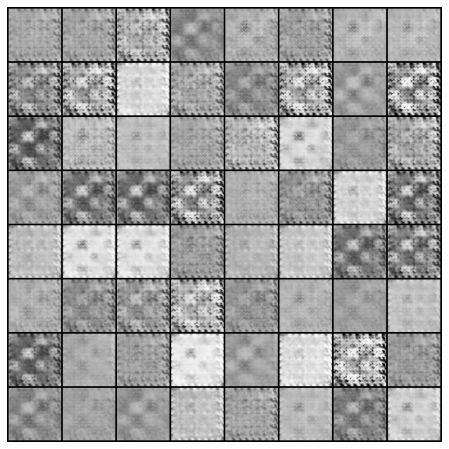

In [9]:
animate_gen_imgs()

# Trian : izif E

In [10]:
DC.eval()
D.eval()

kappa = 1.0
EC_losses = []

iters = 0
AE_img_list = []

def train_AE(epoch):
    global epochs
    global iters
    global EC_losses
    global AE_img_list
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        real_imgs = data[0].to(device)
        
        EC_optimizer.zero_grad()
        
        EC_validity = EC(real_imgs)
        
        fake_imgs = DC(EC_validity)
        
        _, real_features = D.forward(real_imgs)
        _, fake_features = D.forward(fake_imgs)
        
        
        # izif architecture
        imgs_loss = AE_criterion(real_imgs, fake_imgs)
        features_loss = AE_criterion(real_features, fake_features)
        EC_loss = imgs_loss + kappa*features_loss
        
        EC_loss.backward()
        EC_optimizer.step()
        
        # =============================================================
        # print
        # =============================================================
        print('[%d/%d][%d/%d]\n- E_loss: %.4f\n'
              %(epoch+1, epochs, i, len(data_loader), EC_loss.item()))
        
        # Save Losses for plotting later
        EC_losses.append(EC_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = DC(EC_validity).detach().cpu()
            AE_img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(E.state_dict(), 'E.ckpt')

In [11]:
for epoch in range(epochs):
    train_AE(epoch)

[1/100][0/15]
- E_loss: 0.0987

[1/100][1/15]
- E_loss: 0.0952

[1/100][2/15]
- E_loss: 0.0930

[1/100][3/15]
- E_loss: 0.0931

[1/100][4/15]
- E_loss: 0.0831

[1/100][5/15]
- E_loss: 0.0860

[1/100][6/15]
- E_loss: 0.0809

[1/100][7/15]
- E_loss: 0.0718

[1/100][8/15]
- E_loss: 0.0806

[1/100][9/15]
- E_loss: 0.0623

[1/100][10/15]
- E_loss: 0.0794

[1/100][11/15]
- E_loss: 0.0619

[1/100][12/15]
- E_loss: 0.0781

[1/100][13/15]
- E_loss: 0.0823

[1/100][14/15]
- E_loss: 0.0517

[2/100][0/15]
- E_loss: 0.0647

[2/100][1/15]
- E_loss: 0.0635

[2/100][2/15]
- E_loss: 0.0591

[2/100][3/15]
- E_loss: 0.0528

[2/100][4/15]
- E_loss: 0.0789

[2/100][5/15]
- E_loss: 0.0664

[2/100][6/15]
- E_loss: 0.0639

[2/100][7/15]
- E_loss: 0.0574

[2/100][8/15]
- E_loss: 0.0570

[2/100][9/15]
- E_loss: 0.0516

[2/100][10/15]
- E_loss: 0.0651

[2/100][11/15]
- E_loss: 0.0611

[2/100][12/15]
- E_loss: 0.0630

[2/100][13/15]
- E_loss: 0.0442

[2/100][14/15]
- E_loss: 0.0390

[3/100][0/15]
- E_loss: 0.0470

[17/100][12/15]
- E_loss: 0.0493

[17/100][13/15]
- E_loss: 0.0426

[17/100][14/15]
- E_loss: 0.0575

[18/100][0/15]
- E_loss: 0.0417

[18/100][1/15]
- E_loss: 0.0518

[18/100][2/15]
- E_loss: 0.0464

[18/100][3/15]
- E_loss: 0.0456

[18/100][4/15]
- E_loss: 0.0499

[18/100][5/15]
- E_loss: 0.0375

[18/100][6/15]
- E_loss: 0.0432

[18/100][7/15]
- E_loss: 0.0435

[18/100][8/15]
- E_loss: 0.0351

[18/100][9/15]
- E_loss: 0.0425

[18/100][10/15]
- E_loss: 0.0485

[18/100][11/15]
- E_loss: 0.0460

[18/100][12/15]
- E_loss: 0.0489

[18/100][13/15]
- E_loss: 0.0477

[18/100][14/15]
- E_loss: 0.0475

[19/100][0/15]
- E_loss: 0.0559

[19/100][1/15]
- E_loss: 0.0396

[19/100][2/15]
- E_loss: 0.0566

[19/100][3/15]
- E_loss: 0.0404

[19/100][4/15]
- E_loss: 0.0516

[19/100][5/15]
- E_loss: 0.0418

[19/100][6/15]
- E_loss: 0.0451

[19/100][7/15]
- E_loss: 0.0445

[19/100][8/15]
- E_loss: 0.0404

[19/100][9/15]
- E_loss: 0.0427

[19/100][10/15]
- E_loss: 0.0466

[19/100][11/15]
- E_loss: 0.0461



[34/100][3/15]
- E_loss: 0.0443

[34/100][4/15]
- E_loss: 0.0426

[34/100][5/15]
- E_loss: 0.0457

[34/100][6/15]
- E_loss: 0.0373

[34/100][7/15]
- E_loss: 0.0579

[34/100][8/15]
- E_loss: 0.0329

[34/100][9/15]
- E_loss: 0.0467

[34/100][10/15]
- E_loss: 0.0410

[34/100][11/15]
- E_loss: 0.0537

[34/100][12/15]
- E_loss: 0.0447

[34/100][13/15]
- E_loss: 0.0445

[34/100][14/15]
- E_loss: 0.0417

[35/100][0/15]
- E_loss: 0.0373

[35/100][1/15]
- E_loss: 0.0423

[35/100][2/15]
- E_loss: 0.0411

[35/100][3/15]
- E_loss: 0.0396

[35/100][4/15]
- E_loss: 0.0472

[35/100][5/15]
- E_loss: 0.0405

[35/100][6/15]
- E_loss: 0.0455

[35/100][7/15]
- E_loss: 0.0352

[35/100][8/15]
- E_loss: 0.0505

[35/100][9/15]
- E_loss: 0.0421

[35/100][10/15]
- E_loss: 0.0433

[35/100][11/15]
- E_loss: 0.0454

[35/100][12/15]
- E_loss: 0.0506

[35/100][13/15]
- E_loss: 0.0511

[35/100][14/15]
- E_loss: 0.0430

[36/100][0/15]
- E_loss: 0.0386

[36/100][1/15]
- E_loss: 0.0428

[36/100][2/15]
- E_loss: 0.0524



[50/100][9/15]
- E_loss: 0.0465

[50/100][10/15]
- E_loss: 0.0324

[50/100][11/15]
- E_loss: 0.0436

[50/100][12/15]
- E_loss: 0.0403

[50/100][13/15]
- E_loss: 0.0542

[50/100][14/15]
- E_loss: 0.0351

[51/100][0/15]
- E_loss: 0.0468

[51/100][1/15]
- E_loss: 0.0511

[51/100][2/15]
- E_loss: 0.0357

[51/100][3/15]
- E_loss: 0.0358

[51/100][4/15]
- E_loss: 0.0396

[51/100][5/15]
- E_loss: 0.0478

[51/100][6/15]
- E_loss: 0.0447

[51/100][7/15]
- E_loss: 0.0421

[51/100][8/15]
- E_loss: 0.0413

[51/100][9/15]
- E_loss: 0.0506

[51/100][10/15]
- E_loss: 0.0407

[51/100][11/15]
- E_loss: 0.0405

[51/100][12/15]
- E_loss: 0.0476

[51/100][13/15]
- E_loss: 0.0438

[51/100][14/15]
- E_loss: 0.0429

[52/100][0/15]
- E_loss: 0.0446

[52/100][1/15]
- E_loss: 0.0433

[52/100][2/15]
- E_loss: 0.0457

[52/100][3/15]
- E_loss: 0.0462

[52/100][4/15]
- E_loss: 0.0387

[52/100][5/15]
- E_loss: 0.0496

[52/100][6/15]
- E_loss: 0.0387

[52/100][7/15]
- E_loss: 0.0511

[52/100][8/15]
- E_loss: 0.0478



[67/100][0/15]
- E_loss: 0.0411

[67/100][1/15]
- E_loss: 0.0524

[67/100][2/15]
- E_loss: 0.0400

[67/100][3/15]
- E_loss: 0.0384

[67/100][4/15]
- E_loss: 0.0393

[67/100][5/15]
- E_loss: 0.0369

[67/100][6/15]
- E_loss: 0.0406

[67/100][7/15]
- E_loss: 0.0426

[67/100][8/15]
- E_loss: 0.0460

[67/100][9/15]
- E_loss: 0.0416

[67/100][10/15]
- E_loss: 0.0514

[67/100][11/15]
- E_loss: 0.0525

[67/100][12/15]
- E_loss: 0.0371

[67/100][13/15]
- E_loss: 0.0452

[67/100][14/15]
- E_loss: 0.0381

[68/100][0/15]
- E_loss: 0.0472

[68/100][1/15]
- E_loss: 0.0406

[68/100][2/15]
- E_loss: 0.0458

[68/100][3/15]
- E_loss: 0.0478

[68/100][4/15]
- E_loss: 0.0443

[68/100][5/15]
- E_loss: 0.0447

[68/100][6/15]
- E_loss: 0.0353

[68/100][7/15]
- E_loss: 0.0370

[68/100][8/15]
- E_loss: 0.0421

[68/100][9/15]
- E_loss: 0.0471

[68/100][10/15]
- E_loss: 0.0474

[68/100][11/15]
- E_loss: 0.0391

[68/100][12/15]
- E_loss: 0.0387

[68/100][13/15]
- E_loss: 0.0418

[68/100][14/15]
- E_loss: 0.0463



[83/100][6/15]
- E_loss: 0.0372

[83/100][7/15]
- E_loss: 0.0442

[83/100][8/15]
- E_loss: 0.0382

[83/100][9/15]
- E_loss: 0.0516

[83/100][10/15]
- E_loss: 0.0456

[83/100][11/15]
- E_loss: 0.0449

[83/100][12/15]
- E_loss: 0.0420

[83/100][13/15]
- E_loss: 0.0426

[83/100][14/15]
- E_loss: 0.0382

[84/100][0/15]
- E_loss: 0.0478

[84/100][1/15]
- E_loss: 0.0416

[84/100][2/15]
- E_loss: 0.0398

[84/100][3/15]
- E_loss: 0.0351

[84/100][4/15]
- E_loss: 0.0409

[84/100][5/15]
- E_loss: 0.0428

[84/100][6/15]
- E_loss: 0.0393

[84/100][7/15]
- E_loss: 0.0362

[84/100][8/15]
- E_loss: 0.0472

[84/100][9/15]
- E_loss: 0.0468

[84/100][10/15]
- E_loss: 0.0394

[84/100][11/15]
- E_loss: 0.0467

[84/100][12/15]
- E_loss: 0.0456

[84/100][13/15]
- E_loss: 0.0309

[84/100][14/15]
- E_loss: 0.0464

[85/100][0/15]
- E_loss: 0.0394

[85/100][1/15]
- E_loss: 0.0396

[85/100][2/15]
- E_loss: 0.0437

[85/100][3/15]
- E_loss: 0.0393

[85/100][4/15]
- E_loss: 0.0532

[85/100][5/15]
- E_loss: 0.0393



[99/100][12/15]
- E_loss: 0.0561

[99/100][13/15]
- E_loss: 0.0426

[99/100][14/15]
- E_loss: 0.0455

[100/100][0/15]
- E_loss: 0.0448

[100/100][1/15]
- E_loss: 0.0457

[100/100][2/15]
- E_loss: 0.0392

[100/100][3/15]
- E_loss: 0.0319

[100/100][4/15]
- E_loss: 0.0521

[100/100][5/15]
- E_loss: 0.0340

[100/100][6/15]
- E_loss: 0.0482

[100/100][7/15]
- E_loss: 0.0453

[100/100][8/15]
- E_loss: 0.0495

[100/100][9/15]
- E_loss: 0.0400

[100/100][10/15]
- E_loss: 0.0373

[100/100][11/15]
- E_loss: 0.0413

[100/100][12/15]
- E_loss: 0.0379

[100/100][13/15]
- E_loss: 0.0381

[100/100][14/15]
- E_loss: 0.0506



# Loss Graph

In [12]:
def plot_train_loss():
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(DC_losses, label="G")
    plt.plot(D_losses, label="D")
    plt.plot(EC_losses, label="E")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

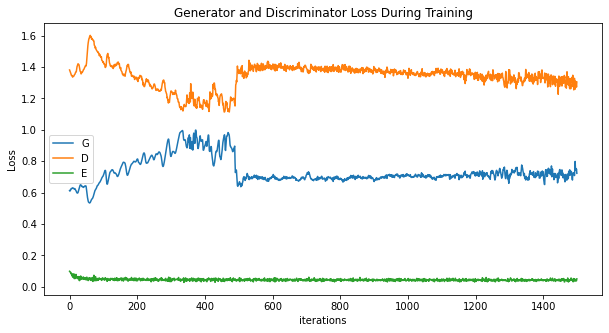

In [13]:
plot_train_loss()

---

# Test Data

In [14]:
#test_data_root = "../../dataset/test/test_DualPhaseSteel"
DP_test_data_root = "../../dataset/test/test_DualPhaseSteel"

test_data_set = dataset.ImageFolder(root = DP_test_data_root, # test_data_root,
                           transform = transforms.Compose([
                                  transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

# 배치로 나누고 셔플하기
test_data_loader = torch.utils.data.DataLoader(test_data_set, batch_size = 1,
                                              shuffle = False, num_workers = workers)

# 이상 픽셀 수 확인 함수

In [15]:
def count_el_not_0(diff_img):
    count_el_not_0 = 0
    
    col_size = diff_img.shape[0]
    row_size = diff_img.shape[1]
    
    #print(col_size, row_size)
    
    for col in range(col_size):
        for row in range(row_size):
            if diff_img[col][row] != 0:
                count_el_not_0 += 1
                
    return count_el_not_0

# img 비교 함수

In [16]:
def compare_imgs(real_img, generated_img, i, score, reverse=False, threshold=50):
    real_img = real_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    generated_img = generated_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    
    negative = np.zeros_like(real_img)

    if not reverse:
        diff_img = real_img - generated_img
    else:
        diff_img = generated_img - real_img

    diff_img[diff_img <= threshold] = 0

    # 분율 추출
    diff_cnts.append(count_el_not_0(diff_img))
    # 분산 추출
    diff_points.append(np.where(diff_img > threshold))
    
    anomaly_img = np.zeros(shape=(img_size, img_size, 3))
    anomaly_img[:, :, 0] = real_img - diff_img
    anomaly_img[:, :, 1] = real_img - diff_img
    anomaly_img[:, :, 2] = real_img - diff_img
    anomaly_img[:, :, 0] = anomaly_img[:,:,0] + diff_img
    anomaly_img = anomaly_img.astype(np.uint8)

    # anomaly_img 추출
    anomaly_imgs.append(anomaly_img)
    
    fig, plots = plt.subplots(1, 4)

    fig.suptitle(f'Anomaly - (anomaly score: {score:.4})')
    
    fig.set_figwidth(9)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='gray', label = "real")
    plots[1].imshow(generated_img, cmap='gray')
    plots[2].imshow(diff_img, cmap='gray')
    plots[3].imshow(anomaly_img)
    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')
    plt.show()

# Test

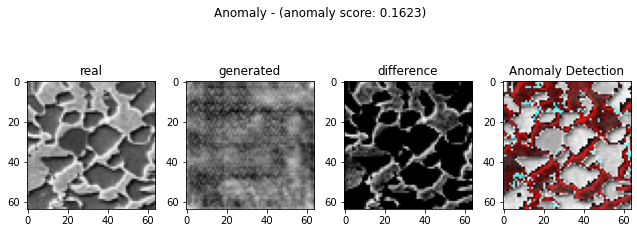

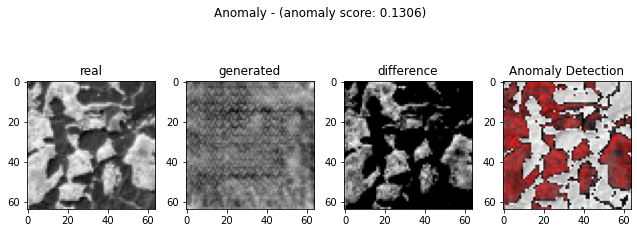

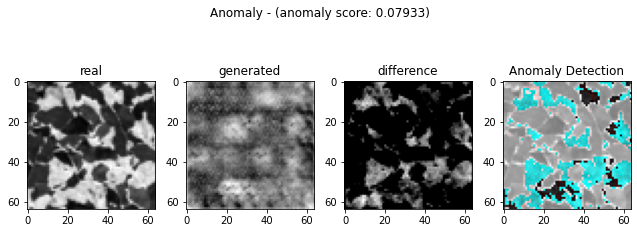

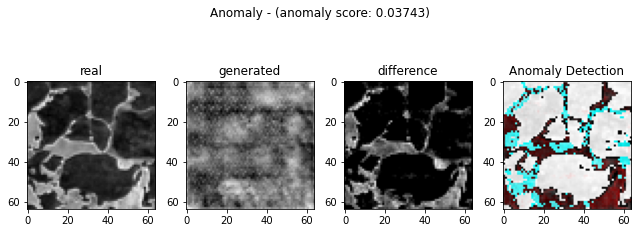

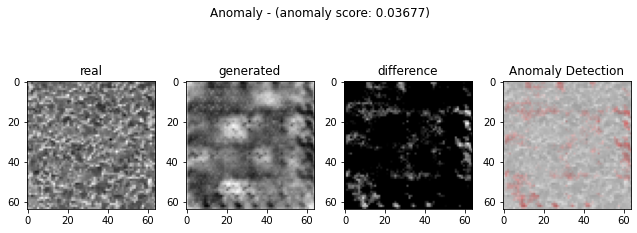

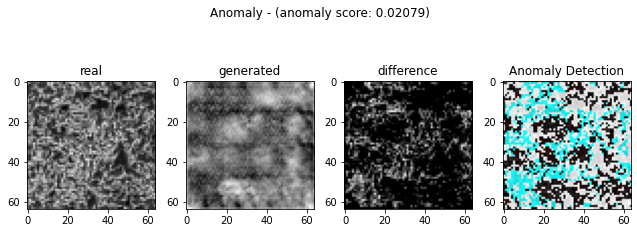

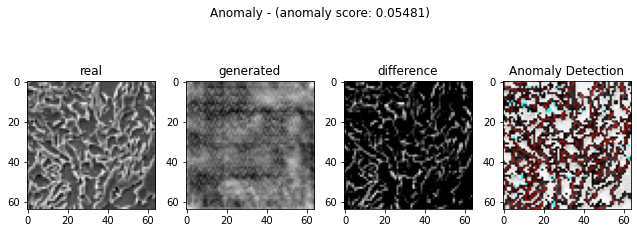

In [17]:
diff_cnts = []
diff_points = []
anomaly_imgs = []

ano_criterion = nn.MSELoss()
DC.eval()
D.eval()
EC.eval()

# with open("score.csv", "w") as f:
#         f.write("label,img_distance,anomaly_score,z_distance\n")

for i, data in enumerate(test_data_loader, 0):
    real_img = data[0].to(device)

    real_z = EC(real_img) # 진짜 이미지의 latent vector
    fake_img = DC(real_z) # DC에 넣어서 가짜 이미지 생성.
    fake_z = EC(fake_img) # torch.Size([1, 100]) --> latent 진짜 이미지와 매핑된 가짜 이미지의 latent vector

    _, real_feature = D.forward(real_img) # 1, 256
    _, fake_feature = D.forward(fake_img)

    img_distance = ano_criterion(fake_img, real_img)
    loss_feature = ano_criterion(fake_feature, real_feature)

    anomaly_score = img_distance + kappa*loss_feature

    z_distance = ano_criterion(fake_z, real_z)
    
#     with open("score.csv", "a") as f:
#             f.write(f"{label.item()},{img_distance},"
#                     f"{anomaly_score},{z_distance}\n")
            
#     print(f"{label.item()}, {img_distance}, "
#           f"{anomaly_score}, {z_distance}\n")
    compare_imgs(real_img, fake_img, i, anomaly_score, reverse = False, threshold = 0.3)

---

# 분율 추출

In [18]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.46972656 0.46899414 0.35986328 0.39135742 0.29125977 0.47949219
 0.40063477]


In [19]:
sum(diff_fraction)/len(diff_fraction)

0.4087611607142857

---

# 분산 추출

In [20]:
from scipy import stats
from extended_int import int_inf

corr_coeffis = []
corr_p_vals = []

def cal_corr_coeffis():
    for idx in range(len(test_data_loader)):
        x_points = diff_points[idx][0]
        y_points = diff_points[idx][1]
        
        
        if len(x_points) > 0:
            corr_coeffi, corr_p_val = stats.pearsonr(x_points, y_points)
        else:
            corr_coeffi, corr_p_val = -int_inf, -int_inf
        
        corr_coeffis.append(corr_coeffi)
        corr_p_vals.append(corr_p_val)

In [21]:
cal_corr_coeffis()

print(corr_coeffis)

[0.0332021200293411, 0.10476159359232183, -0.04419782892181526, 0.04183883630676796, -0.0859687008004156, -0.020073646584960046, -0.051775522965130265]


---

# 모델 저장 및 읽기

In [22]:
save_file = "./pretrained/pretrained.pth"

def save_pretrained():
    pretrained = {
        "D" : D.state_dict(),
        "DC" : DC.state_dict(),
        "EC" : EC.state_dict()
    }

    if not os.path.isdir("pretrained"):
        os.mkdir("pretrained")
    torch.save(pretrained, save_file)

In [23]:
save_pretrained()

In [24]:
pretrained_D = Discriminator().to(device)
pretrained_DC = Decoder().to(device)
pretrained_EC = Encoder().to(device)

def load_pretrained():
    global pretrained_D
    global pretrained_DC
    global pretrained_EC
    
    assert os.path.isdir("pretrained"), "Error : no pretrained dir found!"
    
    pretrained = torch.load(save_file)
    
    pretrained_D.load_state_dict(pretrained["D"])
    pretrained_DC.load_state_dict(pretrained["DC"])
    pretrained_EC.load_state_dict(pretrained["EC"])
    
    #print("pretrained_D :", pretrained_D)
    #print("pretrained_G :", pretrained_DC)
    #print("pretrained_E :", pretrained_EC)

In [25]:
load_pretrained()

In [26]:
def test():
    ano_criterion = nn.MSELoss()
    pretrained_DC.eval()
    pretrained_D.eval()
    pretrained_EC.eval()

    # with open("score.csv", "w") as f:
    #         f.write("label,img_distance,anomaly_score,z_distance\n")

    for i, data in enumerate(test_data_loader, 0):
        real_img = data[0].to(device)

        real_z = pretrained_EC(real_img) # 진짜 이미지의 latent vector
        fake_img = pretrained_DC(real_z) # DC에 넣어서 가짜 이미지 생성.
        fake_z = pretrained_EC(fake_img) # torch.Size([1, 100]) --> latent 진짜 이미지와 매핑된 가짜 이미지의 latent vector

        _, real_feature = pretrained_D.forward(real_img) # 1, 256
        _, fake_feature = pretrained_D.forward(fake_img)

        img_distance = ano_criterion(fake_img, real_img)
        loss_feature = ano_criterion(fake_feature, real_feature)

        anomaly_score = img_distance + kappa*loss_feature

        z_distance = ano_criterion(fake_z, real_z)

    #     with open("score.csv", "a") as f:
    #             f.write(f"{label.item()},{img_distance},"
    #                     f"{anomaly_score},{z_distance}\n")

    #     print(f"{label.item()}, {img_distance}, "
    #           f"{anomaly_score}, {z_distance}\n")
        compare_imgs(real_img, fake_img, i, anomaly_score, reverse = False, threshold = 0.3)

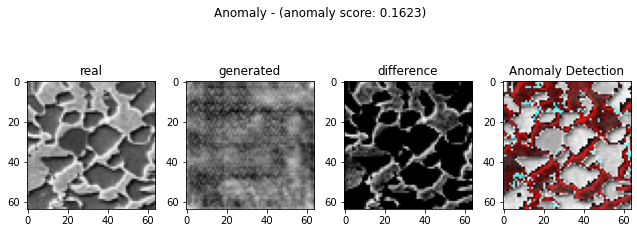

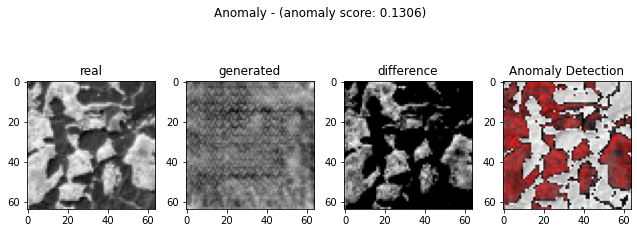

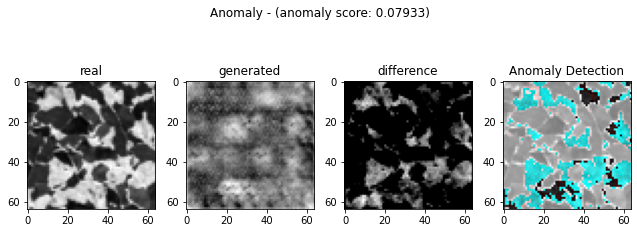

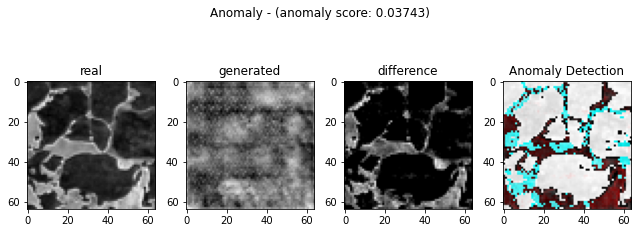

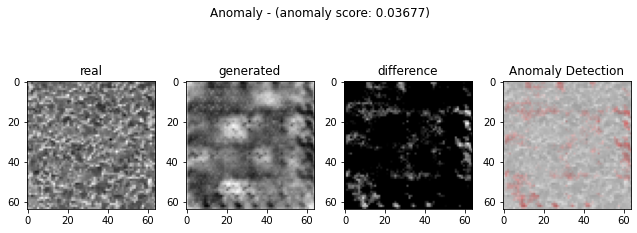

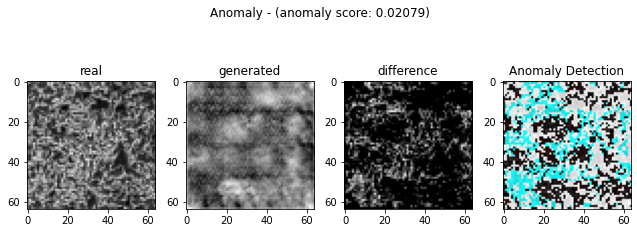

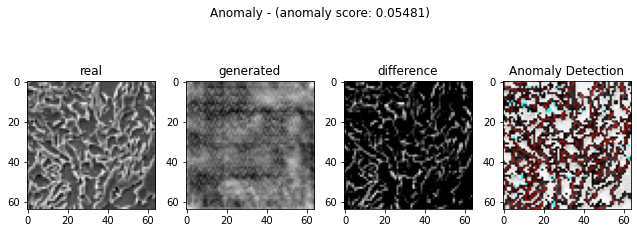

In [27]:
diff_cnts = []
diff_points = []
anomaly_imgs = []

corr_coeffis = []
corr_p_vals = []

test()

In [28]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.46972656 0.46899414 0.35986328 0.39135742 0.29125977 0.47949219
 0.40063477]


In [29]:
cal_corr_coeffis()

print(corr_coeffis)

[0.0332021200293411, 0.10476159359232183, -0.04419782892181526, 0.04183883630676796, -0.0859687008004156, -0.020073646584960046, -0.051775522965130265]


---

# anomaly detection 이미지 추출

In [30]:
anomaly_imgs

[array([[[242, 242, 242],
         [246, 246, 246],
         [121,  43,  43],
         ...,
         [210, 210, 210],
         [176, 176, 176],
         [222, 222, 222]],
 
        [[248, 248, 248],
         [242, 242, 242],
         [ 87,  57,  57],
         ...,
         [238, 238, 238],
         [238, 238, 238],
         [190, 190, 190]],
 
        [[236, 236, 236],
         [230, 230, 230],
         [ 77,  40,  40],
         ...,
         [230, 230, 230],
         [232, 232, 232],
         [238, 238, 238]],
 
        ...,
 
        [[230, 230, 230],
         [248, 248, 248],
         [212, 212, 212],
         ...,
         [142, 142, 142],
         [ 85,  85,  85],
         [130, 130, 130]],
 
        [[228, 228, 228],
         [244, 244, 244],
         [230, 230, 230],
         ...,
         [105, 105, 105],
         [150, 150, 150],
         [252, 252, 252]],
 
        [[218, 218, 218],
         [228, 228, 228],
         [246, 246, 246],
         ...,
         [182, 182, 182],
  

# 이미지 저장 함수

In [31]:
import cv2

def save_imgs(folder, imgs):
    if not os.path.isdir("anomaly_imgs"):
        os.mkdir("anomaly_imgs")
    
    for i in range(len(imgs)):
        cv2.imwrite('%s/%d.png' %(folder,i), imgs[i]) #이미지 저장할 경로 설정을 여기서 한다.
    print("image saving complete")

In [32]:
save_imgs("./anomaly_imgs", anomaly_imgs)

image saving complete


---

# 티타늄(Ti64) 상대 밀도 계산

In [33]:
Ti64_density = 4.43

Ti64_rel_densitys = np.array([])

Ti64_rel_densitys = diff_fraction * Ti64_density

print(Ti64_rel_densitys)

[2.08088867 2.07764404 1.59419434 1.73371338 1.29028076 2.12415039
 1.77481201]
